In [2]:
!pip install opencv-python pyvista
!pip install transformers
import pyvista as pv
import numpy as np
import os
import random
import math
import os
import zipfile
import shutil
import re
import random
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2
import shutil

Checking for archives to unpack in 'cubemaps'...
Unpacking 'Standard-Cube-Map(24).zip' to 'cubemaps/24'...
Unpacking process finished.
Selected random cubemap: '14'
Showing a PyVista plot with the random cubemap as background.


/home/dima/.conda/envs/pylabenv/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


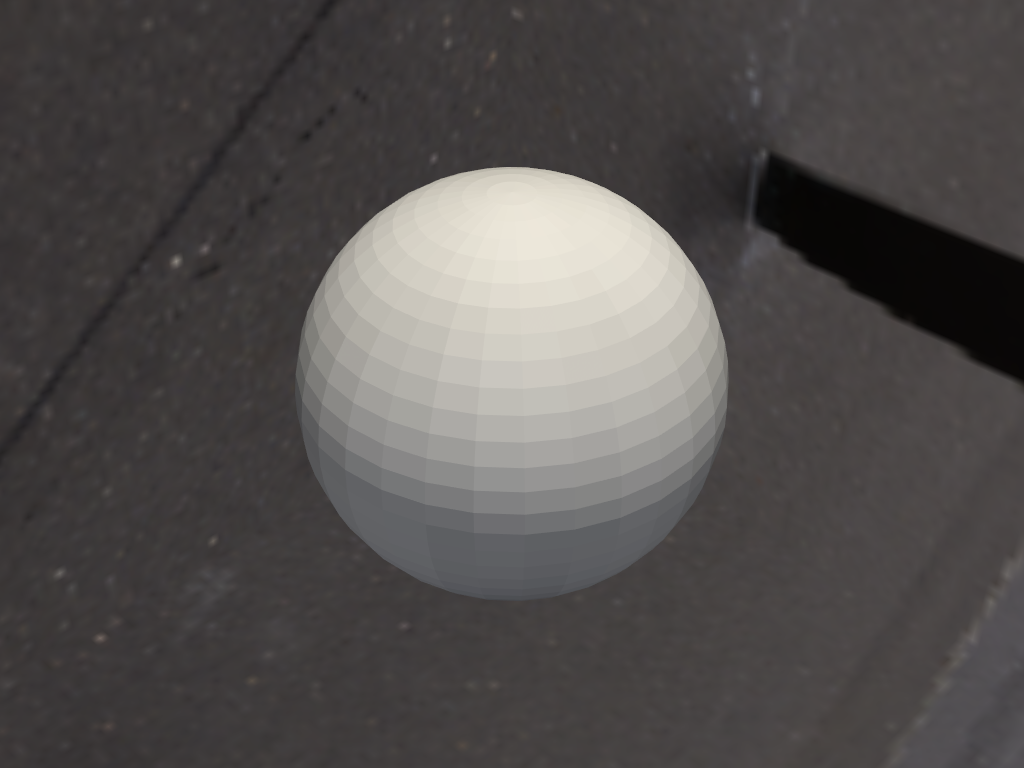

In [ ]:
def unpack_cubemaps(data_dir="cubemaps"):
    """
    Unpacks .zip archives from a directory into structured subfolders.

    Each archive is unpacked into a subdirectory named after a number 'n'.
    The files inside are renamed according to the pattern: n_[pos/neg][x/y/z].png.
    This function is idempotent, meaning it will not re-unpack archives if the
    target directories already exist.

    Args:
        data_dir (str): The path to the directory containing both the .zip files
                        and where the output folders will be created.
    """
    print(f"Checking for archives to unpack in '{data_dir}'...")

    # Ensure the base directory exists
    if not os.path.exists(data_dir):
        print(f"Directory '{data_dir}' not found. Creating it.")
        os.makedirs(data_dir)

    # --- Main loop to iterate through files in the directory ---
    for filename in os.listdir(data_dir):
        if not filename.endswith(".zip"):
            continue

        # --- Determine the number 'n' from the archive's filename ---
        if filename == "Standard-Cube-Map.zip":
            n = 0
        else:
            # Use a regular expression to find the number in parentheses, e.g., (1), (12)
            match = re.search(r"\((\d+)\)", filename)
            if match:
                n = int(match.group(1))
            else:
                continue  # Skip .zip files that don't match the expected naming pattern

        # --- Create the target directory for the current cubemap ---
        new_dir_path = os.path.join(data_dir, str(n))

        # --- Unpack only if the directory doesn't already exist ---
        if os.path.exists(new_dir_path):
            # print(f"Directory '{new_dir_path}' already exists. Skipping unpack.")
            continue

        print(f"Unpacking '{filename}' to '{new_dir_path}'...")
        os.makedirs(new_dir_path)

        # --- Unpack and rename files ---
        zip_path = os.path.join(data_dir, filename)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            for member in zip_ref.namelist():
                original_name = os.path.basename(member)

                # Skip directories or non-PNG files within the archive
                if not original_name or not original_name.endswith(".png"):
                    continue

                # Logic to determine the new filename
                prefix_char = original_name[0]  # 'n' or 'p'
                axis_char = original_name[1]  # 'x', 'y', or 'z'
                side = "neg" if prefix_char == "n" else "pos"

                # Format the new name: e.g., "2_posx.png"
                new_name = f"{n}_{side}{axis_char}.png"
                target_path = os.path.join(new_dir_path, new_name)

                # Extract the file and save it with the new name
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    shutil.copyfileobj(source, target)

    print("Unpacking process finished.")


def get_random_pyvista_cubemap(data_dir="cubemaps"):
    """
    Selects a random cubemap from the data directory and returns it as a PyVista object.

    This function first ensures all cubemaps are unpacked. Then, it randomly
    chooses one of the numbered subdirectories and loads the corresponding
    cubemap textures using pyvista.

    Args:
        data_dir (str): The directory containing the numbered cubemap folders.

    Returns:
        pyvista.Texture: A PyVista cubemap texture object, or None if no
                         cubemaps are found or PyVista is not installed.
    """
    if pv is None:
        print(
            "Error: PyVista library is not installed. Please install it with 'pip install pyvista'"
        )
        return None

    # Step 1: Ensure all archives are unpacked into their respective folders.
    unpack_cubemaps(data_dir)

    # Step 2: Find all valid, numbered cubemap directories.
    try:
        subdirs = [
            d
            for d in os.listdir(data_dir)
            if os.path.isdir(os.path.join(data_dir, d)) and d.isdigit()
        ]
    except FileNotFoundError:
        print(f"Error: Data directory '{data_dir}' not found.")
        return None

    if not subdirs:
        print(f"Error: No numbered cubemap directories found in '{data_dir}'.")
        return None

    # Step 3: Choose a random cubemap directory.
    random_n = random.choice(subdirs)
    print(f"Selected random cubemap: '{random_n}'")

    # Step 4: Define the parameters for PyVista.
    # The path to the directory containing the 6 images.
    cubemap_path = os.path.join(data_dir, random_n)
    # The prefix for the image files, e.g., "2_". PyVista will append "posx", "negy", etc.
    cubemap_prefix = f"{random_n}_"
    # The file extension.
    cubemap_ext = ".png"

    # Step 5: Create and return the PyVista cubemap object.
    return pv.cubemap(cubemap_path, cubemap_prefix, cubemap_ext)


# --- Example Usage ---
if __name__ == "__main__":
    # Define the directory where your 'Standard-Cube-Map.zip', 'Cube-Map(1).zip', etc. are located.
    CUBEMAPS_DIRECTORY = "cubemaps"

    # Get a random cubemap.
    random_cubemap = get_random_pyvista_cubemap(CUBEMAPS_DIRECTORY)

    if random_cubemap:
        # If the cubemap was loaded successfully, you can use it in a PyVista plot.
        # For example, let's create a sphere and add the cubemap as a background.

        # Ensure PyVista is installed for this part to run
        if pv:
            # Create a plotter
            plotter = pv.Plotter()

            # Add a reflective sphere to the scene to showcase the cubemap
            sphere = pv.Sphere()
            plotter.add_mesh(sphere, color="white", metallic=1.0, roughness=0.1)

            # Add the cubemap as a background texture
            plotter.add_actor(random_cubemap.to_skybox())
            plotter.set_environment_texture(random_cubemap)  # For reflections

            print("Showing a PyVista plot with the random cubemap as background.")
            plotter.show()
        else:
            print("Cannot display plot because PyVista is not installed.")

In [ ]:
import colorsys
import random


def generate_color_palette(
    base_colors: list[str],
    num_variations_per_color: int = 8,
    hue_variation: float = 0.05,
    saturation_variation: float = 0.25,
    lightness_variation: float = 0.25,
) -> list[str]:
    """
    Expands a list of base hex colors into a larger palette by generating random variations.

    Args:
        base_colors: A list of starting hex color strings (e.g., ['#ff0000', '#00ff00']).
        num_variations_per_color: How many new colors to generate for each base color.
        hue_variation: Max random change for hue (color wheel). Small values are best.
        saturation_variation: Max random change for color intensity.
        lightness_variation: Max random change for brightness/darkness.

    Returns:
        A new list of hex color strings including the generated variations.
    """
    new_palette = []
    for hex_color in base_colors:
        # 1. Convert Hex to normalized RGB (0-1)
        hex_color = hex_color.lstrip("#")
        r_norm = int(hex_color[0:2], 16) / 255.0
        g_norm = int(hex_color[2:4], 16) / 255.0
        b_norm = int(hex_color[4:6], 16) / 255.0

        # 2. Convert RGB to HLS
        h, l, s = colorsys.rgb_to_hls(r_norm, g_norm, b_norm)

        # 3. Generate variations
        for _ in range(num_variations_per_color):
            # Generate random offsets
            h_offset = random.uniform(-hue_variation, hue_variation)
            s_offset = random.uniform(-saturation_variation, saturation_variation)
            l_offset = random.uniform(-lightness_variation, lightness_variation)

            # Apply offsets and clamp values to the valid [0, 1] range
            new_h = (h + h_offset) % 1.0  # Hue wraps around
            new_s = max(0.0, min(1.0, s + s_offset))
            new_l = max(0.0, min(1.0, l + l_offset))

            # 4. Convert back to RGB
            new_r, new_g, new_b = colorsys.hls_to_rgb(new_h, new_l, new_s)

            # 5. Convert back to Hex and add to palette
            r_int, g_int, b_int = int(new_r * 255), int(new_g * 255), int(new_b * 255)
            new_hex = f"#{r_int:02x}{g_int:02x}{b_int:02x}"
            new_palette.append(new_hex)

    return base_colors + new_palette

In [ ]:
# true_colors = [
#     "#5d4b3b",
#     "#3634af",
#     "#799886",
#     "#53463a",
#     "#22150a",
#     "#543c30",
#     "#212021",
#     "#72a18d",
#     "#53403b",
#     "#55453a",
#     "#5478cc",
#     "#373d5a",
#     "#614439",
#     "#13100a",
#     "#585858",
#     "#0a0604",
#     "#4f87b0",
#     "#3b6176",
#     "#335746",
#     "#577eae",
#     "#3b412a",
#     "#243551",
#     "#6c6333",
#     "#6c6964",
#     "#322e2a",
#     "#0b0b0b",
#     "#624941",
#     "#554e48",
#     "#534a57",
#     "#704636",
#     "#1a0e09",
#     "#513e27",
#     "#513928",
#     "#734e52",
#     "#464e57",
#     "#6c5c4a",
#     "#58a5d2",
#     "#6c4e3a",
#     "#776831",
#     "#66e9f8",
#     "#76726c",
#     "#54548b",
#     "#38375f",
#     "#404140",
#     "#3d3933",
#     "#76594c",
#     "#3a3832",
#     "#6a892c",
#     "#353836",
#     "#616261",
#     "#060708",
#     "#756c56",
#     "#788f75",
#     "#312c2e",
#     "#5b9d84",
#     "#616569",
#     "#725d4f",
#     "#413839",
#     "#789888",
#     "#7a763c",
#     "#484848",
#     "#4e4b49",
#     "#41758f",
#     "#5c5d60",
#     "#da44aa"
# ]
base_colors = [
    "#da44aa",
    "#66e9f8",
    "#3634af",
    "#6a892c",
    "#b9db52",
    "#7d40e3",
    "#7e4d3e",
    "#d7a7c1",
    "#ffffff",
    "#ffffff#bfe1f7",
    "#a6ad37",
    "#dad068",
    "#4f615c",
    "#a0b27d",
    "#483bba",
    "#9b745b",
    "#9b4090",
    "#b0ff75",
    "#fff573",
    "#ff3f79",
    "#c63429",
    "#51bacc",
    "#6de34c",
]
object_colors = generate_color_palette(base_colors)

In [38]:
# --- Main Configuration ---
RENDER_CONFIG = {
    "output_dir": "renders",
    "textures_dir": "textures",
    "render_modes": ["pbr"] * 10
    + ["wireframe"] * 2
    + ["orthographic"],  # original distribution
    # "render_modes": ["pbr"] * 10,
    "ortho_resolution": (600, 600),  # <--- NEW: Separate resolution for ortho renders
    "object_colors": object_colors,
    # 9 * None, 10* #404040
    # PBR Settings
    "pbr_background_options": [None],
    "pbr_metallic_range": (0.1, 0.8),
    "pbr_roughness_range": (0.3, 0.9),
    "pbr_skybox_chance": 0.4,
    # Wireframe Settings
    "wireframe_color": "white",
    "wireframe_linewidth_range": (1.0, 4.0),
    # --- NEW: Custom Lighting for non-skybox PBR ---
    "pbr_light_intensity_range": (1.0, 3.0),  # How bright the light is. 1.0 is default.
    "pbr_light_color_options": [
        "white",
        "#FFFFE0",
        "#ADD8E6",
        "#ADE6D8",
        "#B3ADE6",
        "#E0E6AD",
        "#E6CFAD",
        "#E6ADCC",
    ],  # White, warm yellow, cool blue
    "pbr_light_distance_range": (4.0, 12.0),  # How far the light is from the object
    # Orthographic Settings
    "ortho_color": "#585858",
    "ortho_bg_color": "#ffffff",
    "ortho_show_edges": True,
    "ortho_edge_color": "#404040",
    "ortho_opacity_chance": 0.4,
    "ortho_opacity_range": (0.4, 0.8),
    # Camera Settings
    "camera_distance_range": (2.0, 10.0),
    "camera_elevation_range": (-20, 80),
}

In [35]:
def normalize_mesh(mesh: pv.PolyData) -> pv.PolyData:
    """
    Normalizes a mesh to fit within a unit cube centered at the origin.
    1. Translates the mesh to the origin.
    2. Scales the mesh so its largest absolute dimension is 1.0.
    """
    mesh.translate(-np.array(mesh.center), inplace=True)

    max_abs_dim = np.max(np.abs(mesh.bounds))

    # Add a check to prevent division by zero for empty or point-like meshes.
    if max_abs_dim > 1e-9:  # Use a small epsilon for floating point safety
        scale_factor = 1.0 / max_abs_dim
        mesh.scale([scale_factor, scale_factor, scale_factor], inplace=True)

    return mesh


# --- Main Renderer Class ---


class STLRenderer:
    def __init__(self, config: dict):
        self.config = config
        print(
            f"Renderer initialized. Available modes: {config.get('render_modes', [])}"
        )

    def generate_render(
        self,
        output_path: str,
        resolution: tuple[int, int],
        mesh: pv.PolyData,
        render_params: dict,
    ):
        plotter = pv.Plotter(off_screen=True, window_size=resolution)

        custom_lights = render_params.get("lights")
        if custom_lights:
            # plotter.remove_all_lights()  # Important: remove default lights
            for light in custom_lights:
                plotter.add_light(light)

        mesh.texture_map_to_plane(inplace=True)
        plotter.add_mesh(
            mesh, reset_camera=False, **render_params.get("mesh_style", {})
        )

        cubemap = render_params.get("cubemap_texture")
        if cubemap:
            plotter.add_actor(cubemap.to_skybox())
            plotter.set_environment_texture(cubemap)
        else:
            plotter.set_background(render_params.get("background_color"))

        if render_params.get("show_axes", False):
            plotter.add_axes(viewport=(0.8, 0, 1, 0.2))

        view_preset = render_params.get("view_preset")
        if view_preset == "isometric":
            plotter.view_isometric()
            plotter.enable_parallel_projection()
        else:
            plotter.camera_position = render_params.get("camera_position")
            plotter.camera.SetDistance(1)
            plotter.disable_parallel_projection()

        # plotter.camera.reset_clipping_range()
        plotter.camera.clipping_range = (0.01, 100)
        plotter.render()
        # plotter.renderer.ResetCameraClippingRange()

        plotter.screenshot(
            output_path,
            transparent_background=(
                render_params.get("background_color") is None and not cubemap
            ),
        )
        plotter.close()

    def generate_random_renders(
        self, stl_path: str, num_renders: int, resolution: tuple[int, int]
    ):
        if not os.path.exists(stl_path):
            print(f"Error: STL file not found at {stl_path}")
            return

        # --- KEY CHANGE: Load and normalize the mesh ONCE ---
        mesh = pv.read(stl_path)
        mesh = normalize_mesh(mesh)  # Apply normalization
        print(
            f"Mesh '{os.path.basename(stl_path)}' normalized successfully. \t {mesh.length=}"
        )

        textures_dir = self.config["textures_dir"]
        texture_files = (
            [
                os.path.join(textures_dir, f)
                for f in os.listdir(textures_dir)
                if f.lower().endswith((".png", ".jpg", ".jpeg"))
            ]
            if os.path.exists(textures_dir)
            else []
        )

        output_dir = self.config["output_dir"]
        os.makedirs(output_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(stl_path))[0]

        print(f"\nGenerating {num_renders} random renders for {base_name}.stl...")

        for i in range(num_renders):
            render_mode = random.choice(self.config["render_modes"])
            params = {"mesh_style": {}}
            log_details = []

            # --- PBR and Wireframe modes now use the simplified camera function ---
            if render_mode == "pbr" or render_mode == "wireframe":
                if render_mode == "pbr":
                    is_skybox = random.random() < self.config.get(
                        "pbr_skybox_chance", 0
                    )
                    params["mesh_style"]["pbr"] = True
                    if is_skybox:
                        params["cubemap_texture"] = get_random_pyvista_cubemap()
                    else:
                        params["background_color"] = random.choice(
                            self.config["pbr_background_options"]
                        )

                        light_pos = get_random_light_position(self.config)
                        light_intensity = random.uniform(
                            *self.config["pbr_light_intensity_range"]
                        )
                        light_color = random.choice(
                            self.config["pbr_light_color_options"]
                        )
                        scene_light = pv.Light(
                            position=light_pos,
                            color=light_color,
                            intensity=light_intensity,
                            light_type="scene light",
                        )
                        params["lights"] = [scene_light]  # Pass light to the renderer
                        log_details.append(f"light:{light_color}")

                    # texture
                    if random.choice([True, False]) and texture_files:
                        params["mesh_style"]["texture"] = pv.read_texture(
                            random.choice(texture_files)
                        )
                    else:
                        params["mesh_style"]["color"] = random.choice(
                            self.config["object_colors"]
                        )
                    params["mesh_style"]["metallic"] = random.uniform(
                        *self.config["pbr_metallic_range"]
                    )
                    params["mesh_style"]["roughness"] = random.uniform(
                        *self.config["pbr_roughness_range"]
                    )
                    params["mesh_style"]["smooth_shading"] = True

                else:  # Wireframe specific logic
                    line_width = random.uniform(
                        *self.config["wireframe_linewidth_range"]
                    )
                    params["mesh_style"] = {
                        "style": "wireframe",
                        "color": self.config["wireframe_color"],
                        "line_width": line_width,
                    }
                    params["background_color"] = "#404040"
                    log_details.append(f"width:{line_width:.1f}")

                # Camera position is now robust for all models
                params["camera_position"] = get_random_camera_position(self.config)

            elif render_mode == "orthographic":
                # Orthographic logic remains the same
                params["mesh_style"] = {
                    "color": self.config["ortho_color"],
                    "show_edges": self.config["ortho_show_edges"],
                    "edge_color": self.config["ortho_edge_color"],
                }
                if random.random() < self.config.get("ortho_opacity_chance", 0):
                    opacity = random.uniform(*self.config["ortho_opacity_range"])
                    params["mesh_style"]["opacity"] = opacity
                    log_details.append(f"opacity:{opacity:.2f}")
                params["background_color"] = self.config["ortho_bg_color"]
                params["view_preset"] = "isometric"
                params["show_axes"] = True

            output_filename = os.path.join(
                output_dir, f"{base_name}_{i + 1}_{render_mode}.png"
            )
            log_str = f"({', '.join(log_details)})" if log_details else ""

            self.generate_render(
                output_path=output_filename,
                resolution=resolution,
                mesh=mesh.copy(),
                render_params=params,
            )
            print(f"  -> Saved {output_filename} {log_str}")


# --- NEW HELPER FUNCTION for Light Positioning ---
def get_random_light_position(config: dict) -> tuple[float, float, float]:
    """Generates a random 3D position for a light source."""
    distance = random.uniform(*config["pbr_light_distance_range"])
    azimuth = random.uniform(0, 360)
    elevation = random.uniform(-80, 80)  # Lights can come from below or above

    elev_rad, azim_rad = math.radians(90 - elevation), math.radians(azimuth)
    x = distance * math.sin(elev_rad) * math.cos(azim_rad)
    y = distance * math.sin(elev_rad) * math.sin(azim_rad)
    z = distance * math.cos(elev_rad)
    return (x, y, z)


def get_random_camera_position(config: dict) -> list:
    """
    Generates a camera position for a NORMALIZED mesh.
    The mesh is assumed to be at the origin and have a size of ~1.0.
    """

    distance = random.uniform(*config["camera_distance_range"])
    azimuth = random.uniform(0, 360)
    elevation = random.uniform(*config["camera_elevation_range"])

    elev_rad, azim_rad = math.radians(90 - elevation), math.radians(azimuth)
    x = distance * math.sin(elev_rad) * math.cos(azim_rad)
    y = distance * math.sin(elev_rad) * math.sin(azim_rad)
    z = distance * math.cos(elev_rad)

    view_up = [0, 0, 1]

    return [(x, y, z), [0, 0, 0], view_up]


if __name__ == "__main__":
    STL_FILE = "model1.stl"
    # NUM_RENDERS = 80
    NUM_RENDERS = 30
    RESOLUTION = (512, 512)

    if not os.path.exists(STL_FILE):
        pv.Cube().save(STL_FILE)
        print(f"Created sample file: {STL_FILE}")
    if not os.path.exists(RENDER_CONFIG["textures_dir"]):
        os.makedirs(RENDER_CONFIG["textures_dir"])
        print(f"Created directory: {RENDER_CONFIG['textures_dir']}")

    renderer = STLRenderer(config=RENDER_CONFIG)
    renderer.generate_random_renders(
        stl_path=STL_FILE,
        num_renders=NUM_RENDERS,
        resolution=RESOLUTION,
    )
    print(f"\nSuccess! All renders saved in '{RENDER_CONFIG['output_dir']}'.")

Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr']
Mesh 'model1.stl' normalized successfully. 	 mesh.length=3.4641016151377544

Generating 30 random renders for model1.stl...
  -> Saved renders/model1_1_pbr.png (light:#E6ADCC)
  -> Saved renders/model1_2_pbr.png (light:#FFFFE0)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '11'
  -> Saved renders/model1_3_pbr.png 
  -> Saved renders/model1_4_pbr.png (light:#E0E6AD)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '11'
  -> Saved renders/model1_5_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '23'
  -> Saved renders/model1_6_pbr.png 
  -> Saved renders/model1_7_pbr.png (light:#E6ADCC)
  -> Saved renders/model1_8_pbr.png (light:#E0E6AD)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finishe

Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
[PosixPath('data/train_data/models/0461.stl'), PosixPath('data/train_data/models/0464.stl'), PosixPath('data/train_data/models/0460.stl'), PosixPath('data/train_data/models/0467.stl'), PosixPath('data/train_data/models/0470.stl'), PosixPath('data/train_data/models/0483.stl'), PosixPath('data/train_data/models/0475.stl'), PosixPath('data/train_data/models/0471.stl'), PosixPath('data/train_data/models/0478.stl'), PosixPath('data/train_data/models/0474.stl'), PosixPath('data/train_data/models/0473.stl'), PosixPath('data/train_data/models/0488.stl'), PosixPath('data/train_data/models/0480.stl'), PosixPath('data/train_data/models/0484.stl'), PosixPath('data/train_data/models/0481.stl'), PosixPath('data/train_data/models/0494.stl'), PosixPath('data/train_data/models/0485.stl'), PosixPath('data/train_data/models/0500.stl'), PosixPath('data/tra

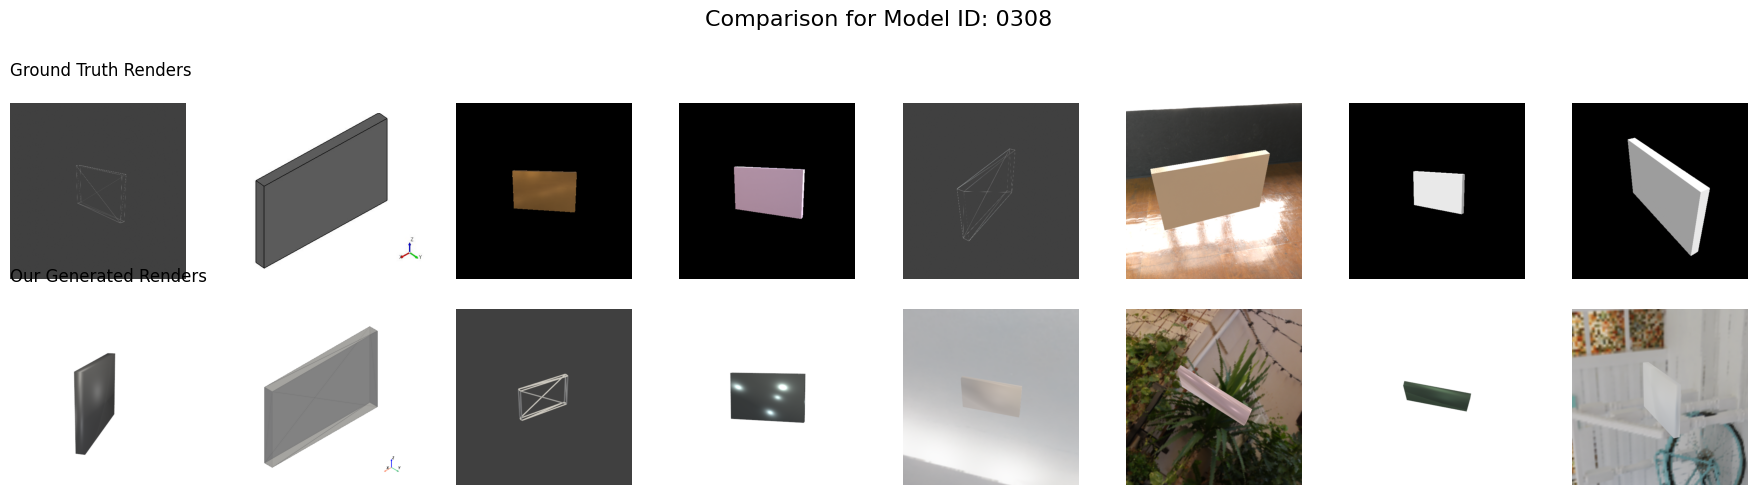

--------------------------------------------------
Processing model: 0301
  -> Found 26 ground truth images.
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0301.stl' normalized successfully. 	 mesh.length=2.7440346047756687

Generating 26 random renders for 0301.stl...
  -> Saved comparison_renders/0301/0301_1_pbr.png 
  -> Saved comparison_renders/0301/0301_2_pbr.png 
  -> Saved comparison_renders/0301/0301_3_pbr.png 
  -> Saved comparison_renders/0301/0301_4_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '15'
  -> Saved comparison_renders/0301/0301_5_pbr.png 
  -> Saved comparison_renders/0301/0301_6_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '2'
  -> Saved comparison_renders/0301/0301_7_pbr.png 
  -> Saved comparison_renders/0301/0301_8_pbr.png

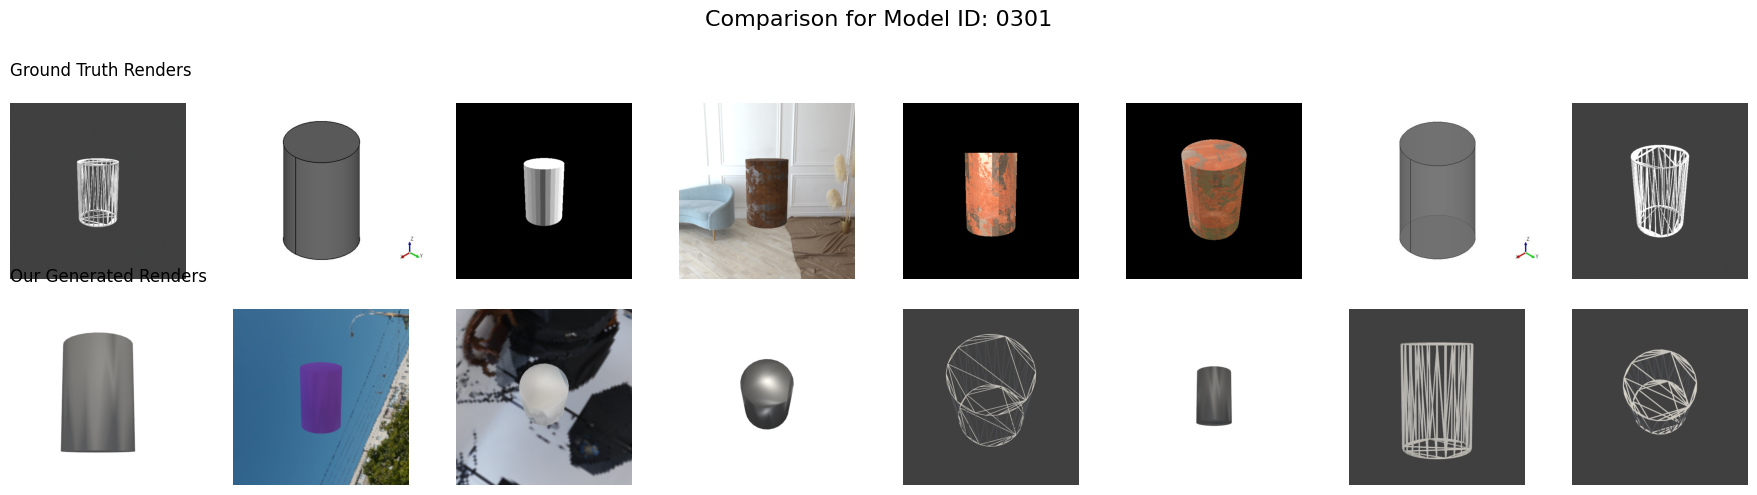

--------------------------------------------------
Processing model: 0318
  -> Found 26 ground truth images.
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0318.stl' normalized successfully. 	 mesh.length=2.8354893759617745

Generating 26 random renders for 0318.stl...
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '3'
  -> Saved comparison_renders/0318/0318_1_pbr.png 
  -> Saved comparison_renders/0318/0318_2_wireframe.png (width:2.8)
  -> Saved comparison_renders/0318/0318_3_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '22'
  -> Saved comparison_renders/0318/0318_4_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '1'
  -> Saved comparison_renders/0318/0318_5_pbr.png 
  -> Saved comparison_render

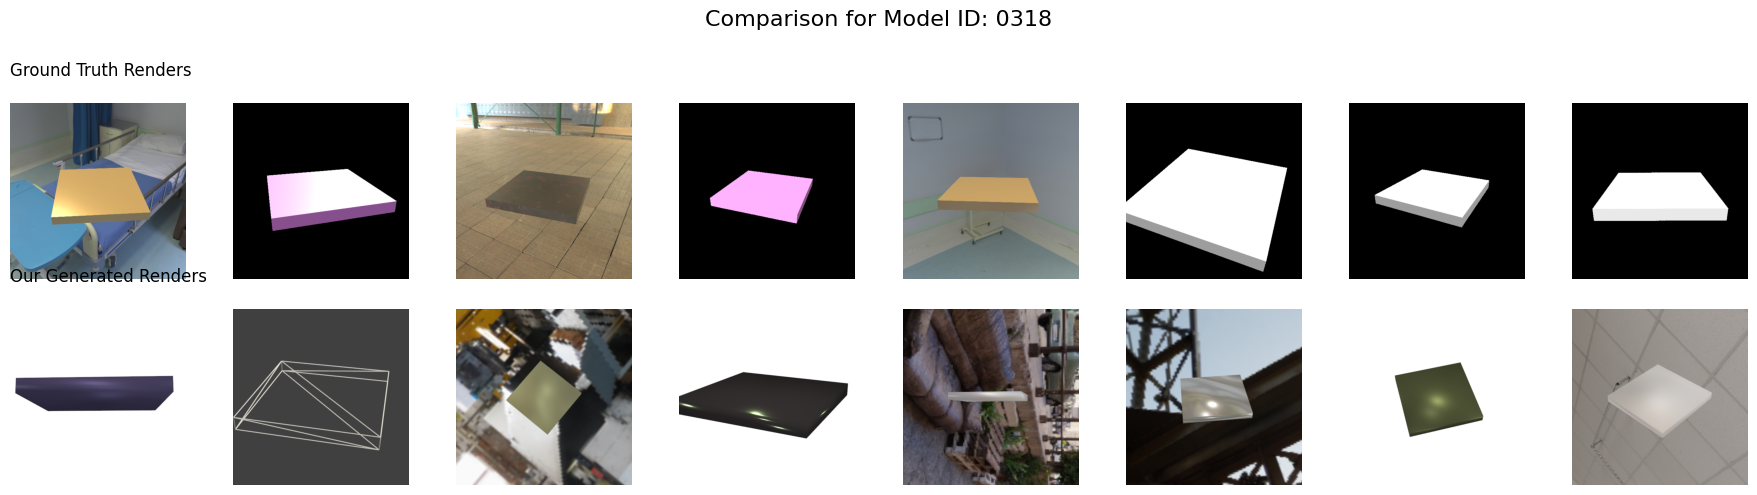

--------------------------------------------------
Comparison finished.


In [ ]:
def visualize_comparison(model_id, ground_truth_paths, generated_paths, num_samples=8):
    """Displays a grid comparing ground truth and generated images."""

    sample_gt = random.sample(
        ground_truth_paths, min(num_samples, len(ground_truth_paths))
    )
    sample_gen = random.sample(generated_paths, min(num_samples, len(generated_paths)))

    fig, axes = plt.subplots(2, num_samples, figsize=(18, 5))
    fig.suptitle(f"Comparison for Model ID: {model_id}", fontsize=16)

    # Top row: Ground Truth
    for i, img_path in enumerate(sample_gt):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title(
                "Ground Truth Renders", loc="left", fontsize=12, pad=20
            )

    # Bottom row: Our Generated Renders
    for i, img_path in enumerate(sample_gen):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title(
                "Our Generated Renders", loc="left", fontsize=12, pad=20
            )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


if __name__ == "__main__":
    # --- Конфигурация ---
    NUM_MODELS_TO_COMPARE = 3
    NUM_RENDERS_PER_MODEL = 26
    RESOLUTION = (512, 512)

    # --- Пути к данным ---
    data_root = Path("data/train_data")
    images_root = data_root / "images"
    models_root = data_root / "models"

    # Временная папка для наших рендеров
    comparison_output_root = Path("comparison_renders")
    if comparison_output_root.exists():
        shutil.rmtree(comparison_output_root)  # Очищаем старые результаты
    comparison_output_root.mkdir()

    # --- Инициализация рендерера ---
    # Убедитесь, что RENDER_CONFIG импортирован из вашего файла renderer.py
    # и содержит правильный путь к папке 'textures'
    if not Path(RENDER_CONFIG["textures_dir"]).exists():
        Path(RENDER_CONFIG["textures_dir"]).mkdir()
        print(f"Created textures directory at: {RENDER_CONFIG['textures_dir']}")

    renderer = STLRenderer(config=RENDER_CONFIG)

    # --- Основной цикл сравнения ---
    all_stl_files = list(models_root.glob("*.stl"))
    print(all_stl_files)
    models_to_compare = random.sample(
        all_stl_files, min(NUM_MODELS_TO_COMPARE, len(all_stl_files))
    )

    for stl_path in models_to_compare:
        model_id = stl_path.stem
        print("-" * 50)
        print(f"Processing model: {model_id}")

        # 1. Находим эталонные рендеры
        ground_truth_images = list(images_root.glob(f"{model_id}_*.png"))
        if not ground_truth_images:
            print(f"  -> No ground truth images found for {model_id}. Skipping.")
            continue

        print(f"  -> Found {len(ground_truth_images)} ground truth images.")

        # 2. Генерируем наши рендеры
        model_render_dir = comparison_output_root / model_id

        # Модифицируем конфиг на лету, чтобы рендеры сохранялись в нужную папку
        temp_config = RENDER_CONFIG.copy()
        temp_config["output_dir"] = str(model_render_dir)

        # Создаем новый экземпляр рендерера с временным конфигом
        temp_renderer = STLRenderer(config=temp_config)
        temp_renderer.generate_random_renders(
            stl_path=str(stl_path),
            num_renders=NUM_RENDERS_PER_MODEL,
            resolution=RESOLUTION,
        )
        generated_images = list(model_render_dir.glob("*.png"))
        print(f"  -> Generated {len(generated_images)} new renders.")

        # 3. Визуализируем сравнение
        visualize_comparison(model_id, ground_truth_images, generated_images)

    print("-" * 50)
    print("Comparison finished.")

In [39]:
# Файл: fid_calculator.py (Updated for monochrome analysis)

import torch
import numpy as np
from PIL import Image
from scipy.linalg import sqrtm
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm


class FIDEvaluator:
    """
    Calculates the Fréchet Inception Distance (FID) between two sets of images
    using CLIP embeddings on their MONOCHROME versions.
    """

    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        model_id = "openai/clip-vit-base-patch32"
        self.model = CLIPModel.from_pretrained(model_id).to(self.device).eval()
        self.processor = CLIPProcessor.from_pretrained(model_id)
        print(f"FIDEvaluator initialized on device: {self.device}")

    @torch.no_grad()
    def get_embeddings(self, image_paths: list, batch_size: int = 32) -> np.ndarray:
        """
        Computes CLIP embeddings for a list of image paths after converting them to monochrome.
        """
        all_features = []
        for i in tqdm(
            range(0, len(image_paths), batch_size),
            desc="Calculating monochrome embeddings",
        ):
            batch_paths = image_paths[i : i + batch_size]

            # --- THIS IS THE ONLY LINE THAT CHANGES ---
            # Convert to grayscale ("L"), then back to 3-channel RGB for CLIP compatibility.
            images = [Image.open(p).convert("L").convert("RGB") for p in batch_paths]

            inputs = self.processor(
                text=None, images=images, return_tensors="pt", padding=True
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            features = self.model.get_image_features(**inputs)
            all_features.append(features.cpu().numpy())

        return np.concatenate(all_features, axis=0)


def calculate_fid(act1: np.ndarray, act2: np.ndarray) -> float:
    """
    Calculates the FID score between two sets of embeddings.
    (This function does not need any changes)
    """
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
# Файл: evaluate_fid.py (Advanced version with per-category FID)

import shutil
from pathlib import Path
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

# Import our custom modules

# --- Image Classification Logic (copied from your request) ---
WHITE_OPAQUE = (255, 255, 255, 255)


def classify_image(image: Path) -> str | None:
    """Classifies an image into render categories based on its corner pixels."""
    if not (image.is_file() and image.name.lower().endswith(".png")):
        return None
    try:
        with Image.open(image) as img:
            if img.mode != "RGBA":
                img = img.convert("RGBA")
            width, height = img.size
            if width < 2 or height < 2:
                return None

            corners = [
                img.getpixel((0, 0)),
                img.getpixel((width - 1, 0)),
                img.getpixel((0, height - 1)),
                img.getpixel((width - 1, height - 1)),
            ]

            if all(pixel[3] == 0 for pixel in corners):
                return "pbr_trans"
            if all(pixel == WHITE_OPAQUE for pixel in corners):
                return "ortho"
            if all(all(60 <= ch <= 68 for ch in p[:3]) for p in corners):
                return "wireframe"
            return "pbr_skybox"
    except Exception as e:
        print(f"Warning: Could not process file {image.name}: {e}")
        return None


# --- Main Evaluation Script ---
if __name__ == "__main__":
    # --- Configuration ---
    DATASET_ROOT = Path("data/train_data")
    NUM_MODELS_TO_EVALUATE = 10
    NUM_RENDERS_PER_MODEL = 26
    RESOLUTION = (512, 512)
    TEMP_RENDER_DIR = Path("temp_generated_renders")

    # --- Initialization ---
    evaluator = FIDEvaluator()
    renderer = STLRenderer(config=RENDER_CONFIG)

    # --- Data Collection ---
    all_stl_files = list((DATASET_ROOT / "models").glob("*.stl"))
    if not all_stl_files:
        print(f"Error: No .stl files found in {DATASET_ROOT / 'models'}")
        exit()

    models_to_evaluate = random.sample(
        all_stl_files, min(NUM_MODELS_TO_EVALUATE, len(all_stl_files))
    )

    # Dictionary to store lists of FID scores for each category across all models
    final_fid_scores = defaultdict(list)

    for stl_path in tqdm(models_to_evaluate, desc="Evaluating models"):
        model_id = stl_path.stem
        print(f"\n----- Processing model: {model_id} -----")

        # 1. Get ground truth images
        gt_images_paths = list((DATASET_ROOT / "images").glob(f"{model_id}_*.png"))
        if len(gt_images_paths) < 5:  # Skip if model has too few images
            print(f"  Skipping model {model_id}, not enough GT images.")
            continue

        # 2. Generate our renders
        if TEMP_RENDER_DIR.exists():
            shutil.rmtree(TEMP_RENDER_DIR)
        TEMP_RENDER_DIR.mkdir()

        temp_config = RENDER_CONFIG.copy()
        temp_config["output_dir"] = str(TEMP_RENDER_DIR)
        temp_renderer = STLRenderer(config=temp_config)
        temp_renderer.generate_random_renders(
            stl_path=str(stl_path),
            num_renders=NUM_RENDERS_PER_MODEL,
            resolution=RESOLUTION,
        )
        gen_images_paths = list(TEMP_RENDER_DIR.glob("*.png"))

        # 3. Classify all images and group them
        gt_classified = defaultdict(list)
        gen_classified = defaultdict(list)

        print("  -> Classifying ground truth images...")
        for p in gt_images_paths:
            category = classify_image(p)
            if category:
                gt_classified[category].append(p)

        print("  -> Classifying generated images...")
        for p in gen_images_paths:
            category = classify_image(p)
            if category:
                gen_classified[category].append(p)

        # 4. Calculate FID for each category for this model
        print("  -> Calculating FID scores per category...")
        all_categories = set(gt_classified.keys()) | set(gen_classified.keys())

        for category in sorted(list(all_categories)):
            gt_paths = gt_classified[category]
            gen_paths = gen_classified[category]

            # FID requires at least 2 samples in each set to compute covariance
            if len(gt_paths) < 2 or len(gen_paths) < 2:
                print(
                    f"    - {category}: Skipped (GT: {len(gt_paths)}, Gen: {len(gen_paths)})"
                )
                continue

            gt_embeds = evaluator.get_embeddings(gt_paths)
            gen_embeds = evaluator.get_embeddings(gen_paths)

            fid_score = calculate_fid(gt_embeds, gen_embeds)
            final_fid_scores[category].append(fid_score)
            print(
                f"    - {category}: FID = {fid_score:.2f} (GT: {len(gt_paths)}, Gen: {len(gen_paths)})"
            )

    # --- Final Report ---
    print("\n" + "=" * 60)
    print("           AVERAGE FID SCORES ACROSS ALL MODELS")
    print("=" * 60)

    # Calculate combined PBR score
    pbr_scores = final_fid_scores.get("pbr_trans", []) + final_fid_scores.get(
        "pbr_skybox", []
    )
    if pbr_scores:
        avg_pbr_fid = np.mean(pbr_scores)
        print(f"  PBR (Combined) : {avg_pbr_fid:.2f}")

    for category, scores in sorted(final_fid_scores.items()):
        if "pbr" not in category and scores:  # Print others if they exist
            avg_fid = np.mean(scores)
            print(f"  {category.capitalize():<15}: {avg_fid:.2f}")

    print("=" * 60)
    print("Lower FID is better. This shows which render types need the most tuning.")

    # Cleanup
    if TEMP_RENDER_DIR.exists():
        shutil.rmtree(TEMP_RENDER_DIR)

FIDEvaluator initialized on device: cuda
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']


Evaluating models:   0%|          | 0/10 [00:00<?, ?it/s]


----- Processing model: 0122 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0122.stl' normalized successfully. 	 mesh.length=2.222261330490624

Generating 26 random renders for 0122.stl...
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '9'
  -> Saved temp_generated_renders/0122_1_pbr.png 
  -> Saved temp_generated_renders/0122_2_orthographic.png (opacity:0.55)
  -> Saved temp_generated_renders/0122_3_pbr.png (light:#ADD8E6)
  -> Saved temp_generated_renders/0122_4_wireframe.png (width:2.1)
  -> Saved temp_generated_renders/0122_5_wireframe.png (width:1.5)
  -> Saved temp_generated_renders/0122_6_pbr.png (light:#B3ADE6)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '8'
  -> Saved temp_generated_renders/0122_7_pbr.png 
Checking for archives to unpack in 'cubemaps

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


    - pbr_skybox: FID = 66.40 (GT: 8, Gen: 9)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


    - pbr_trans: FID = 47.07 (GT: 12, Gen: 11)


Evaluating models:  10%|█         | 1/10 [00:11<01:46, 11.78s/it]

    - wireframe: FID = 21.69 (GT: 4, Gen: 5)

----- Processing model: 0121 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0121.stl' normalized successfully. 	 mesh.length=2.0712315323972694

Generating 26 random renders for 0121.stl...
  -> Saved temp_generated_renders/0121_1_pbr.png (light:#E6ADCC)
  -> Saved temp_generated_renders/0121_2_pbr.png (light:#E0E6AD)
  -> Saved temp_generated_renders/0121_3_wireframe.png (width:2.7)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '9'
  -> Saved temp_generated_renders/0121_4_pbr.png 
  -> Saved temp_generated_renders/0121_5_wireframe.png (width:1.1)
  -> Saved temp_generated_renders/0121_6_pbr.png (light:#E0E6AD)
  -> Saved temp_generated_renders/0121_7_pbr.png (light:#B3ADE6)
  -> Saved temp_generated_renders/0121_8_pbr.png (light:#E6ADCC)
Checking for archives to unpack 

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


    - pbr_skybox: FID = 61.74 (GT: 8, Gen: 9)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


    - pbr_trans: FID = 37.68 (GT: 12, Gen: 10)


Evaluating models:  20%|██        | 2/10 [00:22<01:29, 11.22s/it]

    - wireframe: FID = 26.16 (GT: 4, Gen: 6)

----- Processing model: 0026 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0026.stl' normalized successfully. 	 mesh.length=2.131163901029729

Generating 26 random renders for 0026.stl...
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '9'
  -> Saved temp_generated_renders/0026_1_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '19'
  -> Saved temp_generated_renders/0026_2_pbr.png 
  -> Saved temp_generated_renders/0026_3_wireframe.png (width:3.2)
  -> Saved temp_generated_renders/0026_4_wireframe.png (width:3.3)
  -> Saved temp_generated_renders/0026_5_wireframe.png (width:1.2)
  -> Saved temp_generated_renders/0026_6_orthographic.png 
  -> Saved temp_generated_renders/0026_7_pbr.png (light:#E0E6AD)
  -> Saved

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.00it/s]


    - ortho: FID = 25.18 (GT: 2, Gen: 2)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


    - pbr_skybox: FID = 55.71 (GT: 8, Gen: 8)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


    - pbr_trans: FID = 41.94 (GT: 12, Gen: 11)


Evaluating models:  30%|███       | 3/10 [00:33<01:16, 10.88s/it]

    - wireframe: FID = 34.95 (GT: 4, Gen: 5)

----- Processing model: 0193 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0193.stl' normalized successfully. 	 mesh.length=2.29128784747792

Generating 26 random renders for 0193.stl...
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '12'
  -> Saved temp_generated_renders/0193_1_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '24'
  -> Saved temp_generated_renders/0193_2_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '6'
  -> Saved temp_generated_renders/0193_3_pbr.png 
  -> Saved temp_generated_renders/0193_4_pbr.png (light:#ADD8E6)
  -> Saved temp_generated_renders/0193_5_pbr.png (light:#E0E6AD)
  -> Saved temp_generated_renders/0193_6_wirefram

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


    - pbr_skybox: FID = 63.87 (GT: 8, Gen: 11)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


    - pbr_trans: FID = 36.43 (GT: 12, Gen: 11)


Evaluating models:  40%|████      | 4/10 [00:44<01:06, 11.06s/it]

    - wireframe: FID = 46.43 (GT: 4, Gen: 4)

----- Processing model: 0223 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0223.stl' normalized successfully. 	 mesh.length=2.878201614571727

Generating 26 random renders for 0223.stl...
  -> Saved temp_generated_renders/0223_1_pbr.png (light:#ADD8E6)
  -> Saved temp_generated_renders/0223_2_wireframe.png (width:3.0)
  -> Saved temp_generated_renders/0223_3_wireframe.png (width:1.1)
  -> Saved temp_generated_renders/0223_4_wireframe.png (width:2.7)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '1'
  -> Saved temp_generated_renders/0223_5_pbr.png 
  -> Saved temp_generated_renders/0223_6_orthographic.png (opacity:0.73)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '23'
  -> Saved temp_generated_renders/0223_7_pbr.p

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 45.24it/s]


    - ortho: FID = 14.11 (GT: 2, Gen: 3)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


    - pbr_skybox: FID = 57.40 (GT: 8, Gen: 6)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s]


    - pbr_trans: FID = 38.36 (GT: 12, Gen: 10)


Evaluating models:  50%|█████     | 5/10 [00:55<00:55, 11.09s/it]

    - wireframe: FID = 26.75 (GT: 4, Gen: 7)

----- Processing model: 0166 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0166.stl' normalized successfully. 	 mesh.length=2.77831033608106

Generating 26 random renders for 0166.stl...
  -> Saved temp_generated_renders/0166_1_pbr.png (light:#E6CFAD)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '24'
  -> Saved temp_generated_renders/0166_2_pbr.png 
  -> Saved temp_generated_renders/0166_3_pbr.png (light:white)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '1'
  -> Saved temp_generated_renders/0166_4_pbr.png 
  -> Saved temp_generated_renders/0166_5_wireframe.png (width:1.1)
  -> Saved temp_generated_renders/0166_6_pbr.png (light:#E6CFAD)
  -> Saved temp_generated_renders/0166_7_pbr.png (light:#E6CFAD)
Checking fo

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


    - pbr_skybox: FID = 56.46 (GT: 8, Gen: 9)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


    - pbr_trans: FID = 30.20 (GT: 12, Gen: 13)


Evaluating models:  60%|██████    | 6/10 [01:07<00:44, 11.24s/it]

    - wireframe: FID = 27.32 (GT: 4, Gen: 3)

----- Processing model: 0007 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0007.stl' normalized successfully. 	 mesh.length=2.9059326335851967

Generating 26 random renders for 0007.stl...
  -> Saved temp_generated_renders/0007_1_pbr.png (light:#E6ADCC)
  -> Saved temp_generated_renders/0007_2_pbr.png (light:#E0E6AD)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '22'
  -> Saved temp_generated_renders/0007_3_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '18'
  -> Saved temp_generated_renders/0007_4_pbr.png 
  -> Saved temp_generated_renders/0007_5_wireframe.png (width:3.3)
  -> Saved temp_generated_renders/0007_6_pbr.png (light:#E0E6AD)
  -> Saved temp_generated_renders/0007_7_pbr.png (light:white)
  -> Sav

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.32it/s]


    - ortho: FID = 27.28 (GT: 2, Gen: 2)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


    - pbr_skybox: FID = 64.62 (GT: 8, Gen: 7)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


    - pbr_trans: FID = 30.32 (GT: 12, Gen: 13)


Evaluating models:  70%|███████   | 7/10 [01:14<00:29,  9.90s/it]

    - wireframe: FID = 28.72 (GT: 4, Gen: 4)

----- Processing model: 0203 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0203.stl' normalized successfully. 	 mesh.length=2.8463806963957046

Generating 26 random renders for 0203.stl...
  -> Saved temp_generated_renders/0203_1_orthographic.png (opacity:0.43)
  -> Saved temp_generated_renders/0203_2_pbr.png (light:#ADE6D8)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '10'
  -> Saved temp_generated_renders/0203_3_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '13'
  -> Saved temp_generated_renders/0203_4_pbr.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '2'
  -> Saved temp_generated_renders/0203_5_pbr.png 
Checking for archives to unpack in 'cub

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s]


    - ortho: FID = 21.64 (GT: 2, Gen: 4)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


    - pbr_skybox: FID = 59.67 (GT: 8, Gen: 13)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


    - pbr_trans: FID = 37.35 (GT: 12, Gen: 7)


Evaluating models:  80%|████████  | 8/10 [01:25<00:20, 10.40s/it]

    - wireframe: FID = 49.53 (GT: 4, Gen: 2)

----- Processing model: 0150 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0150.stl' normalized successfully. 	 mesh.length=3.4504408594742406

Generating 26 random renders for 0150.stl...
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '0'
  -> Saved temp_generated_renders/0150_1_pbr.png 
  -> Saved temp_generated_renders/0150_2_wireframe.png (width:2.6)
  -> Saved temp_generated_renders/0150_3_pbr.png (light:#B3ADE6)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '0'
  -> Saved temp_generated_renders/0150_4_pbr.png 
  -> Saved temp_generated_renders/0150_5_pbr.png (light:#ADE6D8)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '1'
  -> Saved temp_generated_render

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.61it/s]


    - ortho: FID = 14.46 (GT: 2, Gen: 2)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


    - pbr_skybox: FID = 54.13 (GT: 8, Gen: 8)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


    - pbr_trans: FID = 37.28 (GT: 12, Gen: 13)


Evaluating models:  90%|█████████ | 9/10 [01:37<00:10, 10.78s/it]

    - wireframe: FID = 27.41 (GT: 4, Gen: 3)

----- Processing model: 0183 -----
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0183.stl' normalized successfully. 	 mesh.length=2.768450645530613

Generating 26 random renders for 0183.stl...
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '22'
  -> Saved temp_generated_renders/0183_1_pbr.png 
  -> Saved temp_generated_renders/0183_2_wireframe.png (width:3.2)
  -> Saved temp_generated_renders/0183_3_pbr.png (light:#B3ADE6)
  -> Saved temp_generated_renders/0183_4_orthographic.png 
  -> Saved temp_generated_renders/0183_5_pbr.png (light:#E0E6AD)
  -> Saved temp_generated_renders/0183_6_wireframe.png (width:3.9)
  -> Saved temp_generated_renders/0183_7_wireframe.png (width:3.7)
  -> Saved temp_generated_renders/0183_8_pbr.png (light:#ADD8E6)
  -> Saved temp_generated_renders/01

Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 25.06it/s]


    - pbr_skybox: FID = 58.30 (GT: 8, Gen: 4)


Calculating monochrome embeddings: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


    - pbr_trans: FID = 35.30 (GT: 12, Gen: 11)


Evaluating models: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]

    - wireframe: FID = 31.43 (GT: 4, Gen: 10)

           AVERAGE FID SCORES ACROSS ALL MODELS
  PBR (Combined) : 48.51
  Ortho          : 20.53
  Wireframe      : 32.04
Lower FID is better. This shows which render types need the most tuning.


In [42]:
for k, v in final_fid_scores.items():
    print(k, np.mean(v))

pbr_skybox 59.830093165031386
pbr_trans 37.19498506793482
wireframe 32.038448980158456
ortho 20.533932117345607


In [ ]:
# Best Config (34.36 FID):

# --- Main Configuration ---
RENDER_CONFIG = {
    "output_dir": "renders",
    "textures_dir": "textures",
    "render_modes": ["pbr", "pbr", "pbr", "wireframe", "orthographic"],
    "ortho_resolution": (600, 600),  # <--- NEW: Separate resolution for ortho renders
    "object_colors": true_colors,
    "background_options": ["black", "grey", "#303030", None],
    # PBR Settings
    "pbr_metallic_range": (0.2, 0.9),
    "pbr_roughness_range": (0.1, 0.8),
    "pbr_mirror_chance": 0.4,
    "pbr_mirror_metallic_range": (0.1, 0.8),
    "pbr_mirror_roughness_range": (0.3, 0.9),
    # Wireframe Settings
    "wireframe_color": "white",
    "wireframe_linewidth_range": (1.0, 4.0),
    # Orthographic Settings
    "ortho_color": "#D3D3D3",
    "ortho_bg_color": "#ffffff",
    "ortho_show_edges": True,
    "ortho_edge_color": "#404040",
    "ortho_opacity_chance": 0.4,
    "ortho_opacity_range": (0.2, 0.7),
    # Camera Settings
    "camera_distance_range": (2.0, 10.5),
    "camera_elevation_range": (-20, 80),
}
